In [1]:
multi_aspect_queries = {
    'Italian place with a burger': ['Italian place', 'burger'],
    'A cafe that also offers beer': ['cafe', 'beer'],
    'Japanese restaurant with pasta': ['Japanese restaurant', 'pasta'],
    'An ice cream shop with bubble tea': ['ice cream shop', 'bubble tea'],
    'I am in search of a fancy Pakistani restaurant with authentic food': ['fancy', 'Pakistani restaurant']
}

In [2]:
import pandas as pd

rird_reviews = (
    pd.read_csv(
        'https://raw.githubusercontent.com/D3Mlab/rir/main/data/50_restaurants_all_rates.csv',
        usecols = ["name", "review_text"]
    )
    .groupby('name')
    .head(5)
    .rename(columns = {'review_text': 'sequence', 'name': 'restaurant'})
)

rird_reviews

,sequence,restaurant
0,Bit of a wait at the door. No problem. Spicy k...,Hokkaido Ramen Santouka
1,"Not sure why, but the shoyu broth and noodle h...",Hokkaido Ramen Santouka
2,It should come to no surprise that I am a huge...,Hokkaido Ramen Santouka
3,"WHAT TO TRY?!Their ramen!! Personally, liked t...",Hokkaido Ramen Santouka
4,Came here on a Sunday at around 6pm and there ...,Hokkaido Ramen Santouka
...,...,...
28737,Is it just me or has kinton ramen decreased th...,KINTON RAMEN
28738,I'm pretty much here for lunch every other wee...,KINTON RAMEN
28739,"This is a super belated review, as I came here...",KINTON RAMEN
28740,"After a crazy week of midterms, assignments, p...",KINTON RAMEN


In [3]:
rird = pd.read_csv('https://raw.githubusercontent.com/D3Mlab/rir/main/data/PMD.csv')

rird_clean = (
    rird
    .rename(columns = {'Restaurant name': 'restaurant', 'If only Low or  High': 'correct'})
    [['query', 'restaurant', 'correct']]
    .assign(
        query_aspects = lambda d: d['query'].map(multi_aspect_queries),
        correct = lambda d: d['correct'].astype(bool)
    )
    .dropna()
    .explode(['query_aspects'])
)

rird_clean

,query,restaurant,correct,query_aspects
67,I am in search of a fancy Pakistani restaurant...,Ding Tai Fung,False,fancy
67,I am in search of a fancy Pakistani restaurant...,Ding Tai Fung,False,Pakistani restaurant
91,Japanese restaurant with pasta,Ding Tai Fung,False,Japanese restaurant
91,Japanese restaurant with pasta,Ding Tai Fung,False,pasta
93,Italian place with a burger,Ding Tai Fung,False,Italian place
...,...,...,...,...
4993,Italian place with a burger,Cactus Club Cafe,False,burger
4996,A cafe that also offers beer,Cactus Club Cafe,True,cafe
4996,A cafe that also offers beer,Cactus Club Cafe,True,beer
4998,An ice cream shop with bubble tea,Cactus Club Cafe,False,ice cream shop


In [4]:
query_entailment_scores = (
    pd.read_json("query_entailment_probabilities.json")
    .explode(['labels', 'scores'])
    .convert_dtypes()
    .merge(rird_reviews)
    .rename(columns = {'labels': 'query', 'scores': 'score'})
)

query_dense_scores = (
    pd.read_csv("query_dense_scores.csv", index_col=0)
    .rename(columns = {'review_text': 'sequence'})
    .merge(rird_reviews)
)

naive_review_scores = pd.concat([
    query_entailment_scores.assign(scorer = "entailment"),
    query_dense_scores.assign(scorer = "dense")
])

grouping_cols = ['query', 'restaurant', 'scorer']
naive_scores = pd.concat(
    [(
        naive_review_scores
        .groupby(grouping_cols)
        ['score'].nlargest(k)
        .groupby(grouping_cols)
        .mean()
        .reset_index()
        .assign(k = k)
    ) for k in range(1, 6)]
)

naive_scores

,query,restaurant,scorer,score,k
0,A cafe that also offers beer,Alchemy Coffee,dense,89.70734,1
1,A cafe that also offers beer,Alchemy Coffee,entailment,0.511506,1
2,A cafe that also offers beer,Bang Bang Ice Cream and Bakery,dense,91.423096,1
3,A cafe that also offers beer,Bang Bang Ice Cream and Bakery,entailment,0.126474,1
4,A cafe that also offers beer,Bannock,dense,90.22422,1
...,...,...,...,...,...
495,Japanese restaurant with pasta,Playa Cabana,entailment,0.009583,5
496,Japanese restaurant with pasta,Ramen Isshin,dense,90.405948,5
497,Japanese restaurant with pasta,Ramen Isshin,entailment,0.346621,5
498,Japanese restaurant with pasta,Real Sports Bar & Grill,dense,82.91146,5


In [5]:
aspect_entailment_scores = (
    pd.read_json("aspect_entailment_probabilities.json")
    .explode(['labels', 'scores'])
    .convert_dtypes()
    .merge(rird_reviews)
    .rename(columns = {'labels': 'aspect', 'scores': 'score'})
)

aspect_dense_scores = (
    pd.read_csv("aspect_dense_scores.csv", index_col=0)
    .rename(columns = {'review_text': 'sequence'})
    .merge(rird_reviews)
)

aspect_review_scores = pd.concat([
    aspect_entailment_scores.assign(scorer = "entailment"),
    aspect_dense_scores.assign(scorer = "dense")
])

grouping_cols = ['aspect', 'restaurant', 'scorer']
aspect_scores = pd.concat(
    [(
        aspect_review_scores
        .groupby(grouping_cols)
        ['score'].nlargest(k)
        .groupby(grouping_cols)
        .mean()
        .reset_index()
        .assign(k = k)
    ) for k in range(1, 6)]
)

aspect_based_scores = (
    aspect_scores
    .rename(columns = {'aspect': 'query_aspects'})
    .merge(rird_clean)
    .groupby(['query', 'restaurant', 'correct', 'scorer', 'k'])
    ['score'].agg(['min', 'mean', 'max', 'prod'])
    .reset_index()
)

aspect_based_scores

,query,restaurant,correct,scorer,k,min,mean,max,prod
0,A cafe that also offers beer,Alchemy Coffee,False,dense,1,84.33687,87.224545,90.11222,7599.782584
1,A cafe that also offers beer,Alchemy Coffee,False,dense,2,83.890573,86.951574,90.012575,7551.206449
2,A cafe that also offers beer,Alchemy Coffee,False,dense,3,83.497218,86.526792,89.556367,7477.707501
3,A cafe that also offers beer,Alchemy Coffee,False,dense,4,82.973764,85.936863,88.899963,7376.364486
4,A cafe that also offers beer,Alchemy Coffee,False,dense,5,82.204137,85.322403,88.440668,7270.188789
...,...,...,...,...,...,...,...,...,...
2495,Japanese restaurant with pasta,Real Sports Bar & Grill,False,entailment,1,0.423185,0.427766,0.432346,0.182962
2496,Japanese restaurant with pasta,Real Sports Bar & Grill,False,entailment,2,0.248134,0.3295,0.410867,0.10195
2497,Japanese restaurant with pasta,Real Sports Bar & Grill,False,entailment,3,0.180237,0.247502,0.314767,0.056733
2498,Japanese restaurant with pasta,Real Sports Bar & Grill,False,entailment,4,0.144557,0.192458,0.24036,0.034746


In [6]:
ranks = (
    naive_scores
    .merge(aspect_based_scores)
    .rename(columns = {'score': 'naive'})
    .melt(id_vars = ['query', 'restaurant', 'scorer', 'correct', 'k'], var_name='method', value_name='score')
    .assign(rank = lambda d: d.groupby(['query', 'scorer', 'method', 'k'])['score'].rank(ascending=False).astype(int))  
    .query("correct")
)

ranks

,query,restaurant,scorer,correct,k,method,score,rank
16,A cafe that also offers beer,Cactus Club Cafe,dense,True,1,naive,90.459785,15
17,A cafe that also offers beer,Cactus Club Cafe,entailment,True,1,naive,0.740563,6
150,An ice cream shop with bubble tea,Kekou Gelato House,dense,True,1,naive,91.83134,5
151,An ice cream shop with bubble tea,Kekou Gelato House,entailment,True,1,naive,0.05838,19
260,I am in search of a fancy Pakistani restaurant...,Lahore Tikka House,dense,True,1,naive,99.19243,1
...,...,...,...,...,...,...,...,...
12261,I am in search of a fancy Pakistani restaurant...,Lahore Tikka House,entailment,True,5,prod,0.399297,1
12334,Italian place with a burger,Gusto 101,dense,True,5,prod,7068.612126,3
12335,Italian place with a burger,Gusto 101,entailment,True,5,prod,0.387962,1
12482,Japanese restaurant with pasta,Nomé Izakaya,dense,True,5,prod,7675.388864,10


In [7]:
def mrr(ranks):
    # Mean reciprocal rank, higher is better
    return (1 / ranks).mean()

from numpy.random import choice, seed
def moe_bootstrap(vals, n_samples = 100000, z = 1.96):
    seed(42)
    samples = choice(vals, size = (len(vals), n_samples))
    sample_means = samples.mean(axis = 0)
    return z * sample_means.std()

mrr_results = (
    ranks
    .assign(rr = lambda d: 1 / d['rank'])
    .groupby(['method', 'scorer', 'k'])
    ['rr'].agg(['mean', moe_bootstrap])
    .reset_index()
)

mrr_results.head()

,method,scorer,k,mean,moe_bootstrap
0,max,dense,1,0.386667,0.276510
1,max,dense,2,0.491667,0.253192
2,max,dense,3,0.458333,0.258894
3,max,dense,4,0.470000,0.267871
4,max,dense,5,0.408182,0.284840


In [8]:
from numpy import median
def moe_bootstrap_median(vals, n_samples = 100000, z = 1.96):
    seed(42)
    samples = choice(vals, size = (len(vals), n_samples))
    sample_medians = median(samples, axis = 0)
    return z * sample_medians.std()

median_rank_results = (
    ranks
    .groupby(['method', 'scorer', 'k'])
    ['rank'].agg(['median', moe_bootstrap_median])
    .reset_index()
)

median_rank_results.head()

,method,scorer,k,median,moe_bootstrap_median
0,max,dense,1,4.0,3.304873
1,max,dense,2,2.0,2.833309
2,max,dense,3,3.0,2.717107
3,max,dense,4,2.0,3.884458
4,max,dense,5,4.0,4.217290


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 3 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RIRD Results MRR.png


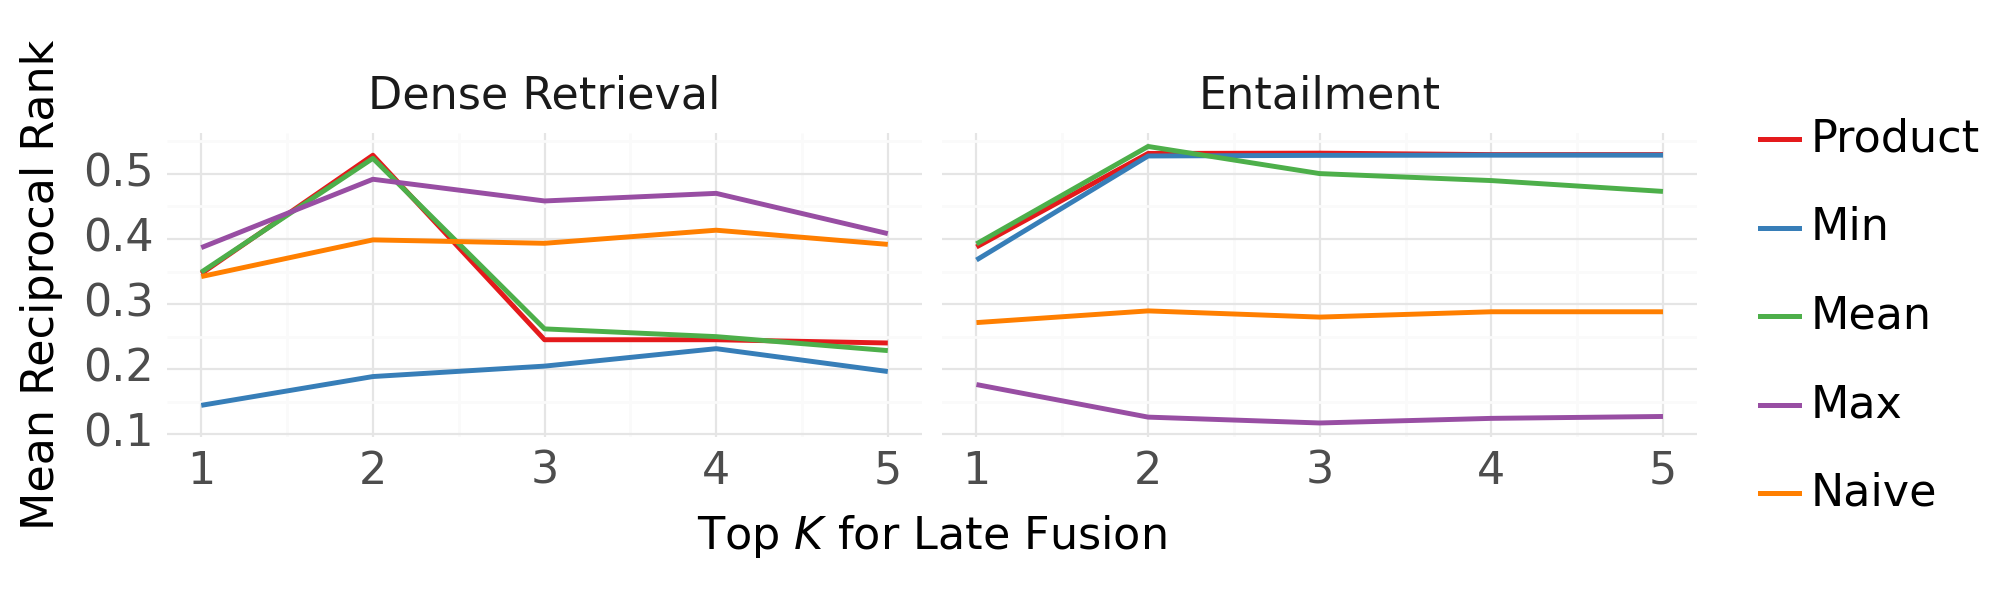

<Figure Size: (1000 x 300)>

In [9]:
from plotnine import *
import numpy as np

p = (
    mrr_results
    .assign(
        method = lambda d: pd.Categorical(d.method.replace({'prod': 'product'}).str.capitalize(), categories = reversed(['Naive', 'Max', 'Mean', 'Min', 'Product'])),
        scorer = lambda d: d.scorer.str.capitalize().replace({'Dense': 'Dense Retrieval'})
    )
    .pipe(ggplot, aes(y = 'mean', x = 'k', color = 'method', fill = 'method')) +
    facet_wrap("scorer") +
    geom_line(size = 1) +
    theme_minimal() +
    scale_color_brewer(type="qual", palette="Set1") +
    labs(y = "Mean Reciprocal Rank", x = "Top $K$ for Late Fusion", color = "", linetype="") +
    theme(figure_size=(10, 3), text=element_text(size=16), legend_entry_spacing_y=16)
)

p.save("RIRD Results MRR.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 3 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RIRD Results Median.png


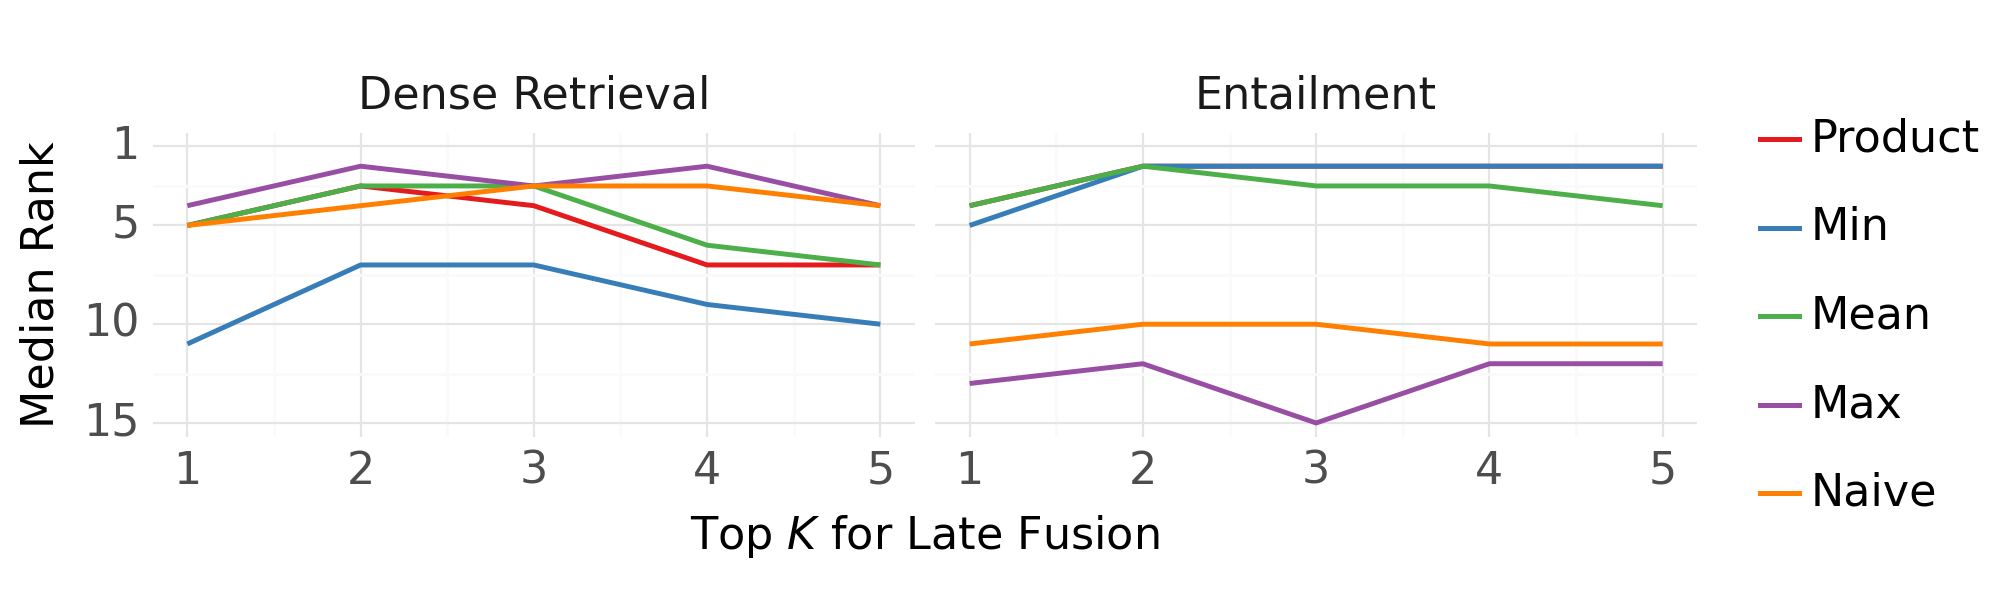

<Figure Size: (1000 x 300)>

In [10]:
p = (
    median_rank_results
    .assign(
        method = lambda d: pd.Categorical(d.method.replace({'prod': 'product'}).str.capitalize(), categories = reversed(['Naive', 'Max', 'Mean', 'Min', 'Product'])),
        scorer = lambda d: d.scorer.str.capitalize().replace({'Dense': 'Dense Retrieval'})
    )
    .pipe(ggplot, aes(y = 'median', x = 'k', color = 'method')) +
    facet_wrap("scorer") +
    geom_line(size = 1) +
    theme_minimal() +
    # scale_y_continuous() +
    scale_y_reverse(breaks = [15, 10, 5, 1], limits = [15, 1]) +
    scale_color_brewer(type="qual", palette="Set1") +
    labs(y = "Median Rank", x = "Top $K$ for Late Fusion", color = "", linetype="") +
    theme(figure_size=(10, 3), text=element_text(size=16), legend_entry_spacing_y=16)
)

p.save("RIRD Results Median.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RIRD Results Ranks.png


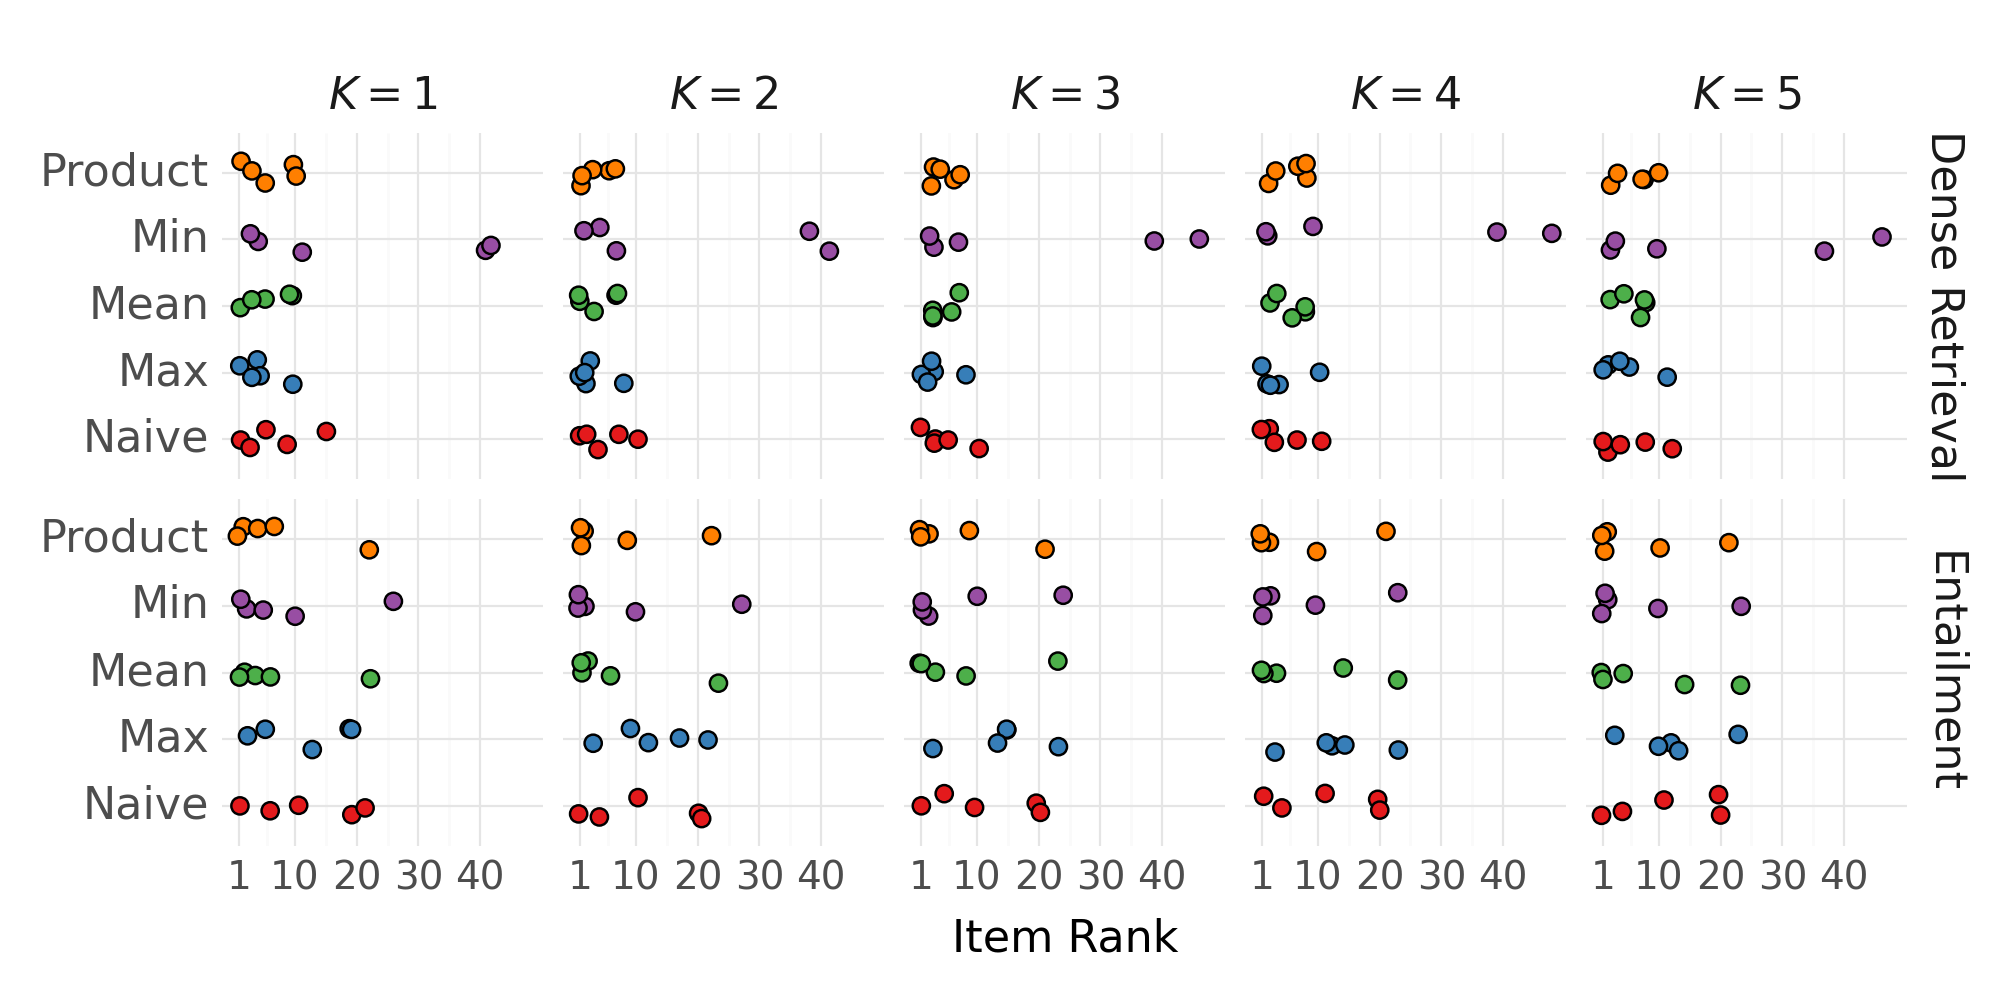

<Figure Size: (1000 x 500)>

In [13]:
p = (
    ranks
    .assign(
        method = lambda d: pd.Categorical(d.method.replace({'prod': 'product'}).str.capitalize(), categories = ['Naive', 'Max', 'Mean', 'Min', 'Product']),
        scorer = lambda d: d.scorer.str.capitalize().replace({'Dense': 'Dense Retrieval'}),
        k = lambda d: "$K = " + d.k.astype(str) + "$"
    )
    .pipe(ggplot, aes(x = 'rank', fill = 'method', y='method')) +
    facet_grid("scorer ~ k") +
    geom_jitter(size = 3, height = 0.2, random_state = 0) +
    theme_minimal() +
    scale_fill_brewer(type="qual", palette="Set1") +
    scale_x_continuous(breaks = [1, 10, 20, 30, 40]) +
    labs(y = "", x = "Item Rank") +
    theme(figure_size=(10, 5), text=element_text(size=16), legend_position='none', axis_text_x=element_text(size=14))
)

p.save("RIRD Results Ranks.png")

p